In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [5]:
img = cv2.imread(r"temp\temp.jpg")
# img = cv2.imread(r"datasets\ID Card (VN) v1\valid\images\1b46ee6f-df7408cb-f7f3-45c2-be54-ca0432648564_jpg.rf.8e46ffa26e0bb04fbdfd239a0eee893f.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)

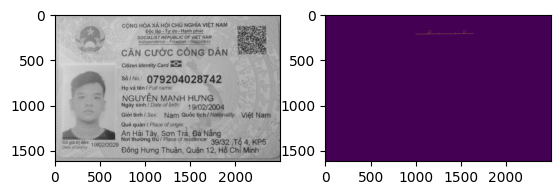

In [8]:
canny_figure = plt.figure()

canny = cv2.Canny(img_blur, threshold1=60, threshold2=400, L2gradient=True)
canny_figure.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
canny_figure.add_subplot(1, 2, 2)
plt.imshow(canny)

In [4]:
lines = cv2.HoughLines(canny, 1, np.pi/180, 105)

img_lines = img.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.show()

TypeError: 'NoneType' object is not iterable

In [ ]:
def intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)  # Giải hệ phương trình tuyến tính
    return int(np.round(x0)), int(np.round(y0))


In [ ]:
horizontal, vertical = [], []

for line in lines:
    rho, theta = line[0]
    if theta < np.pi / 4 or theta > 3 * np.pi / 4:
        vertical.append(line)
    else:
        horizontal.append(line)

intersections = []
for v in vertical:
    for h in horizontal:
        pt = intersection(v, h)
        if pt is not None:
            intersections.append(pt)

C:\Users\hungm\AppData\Local\Temp\ipykernel_17432\3460458537.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(np.round(x0)), int(np.round(y0))


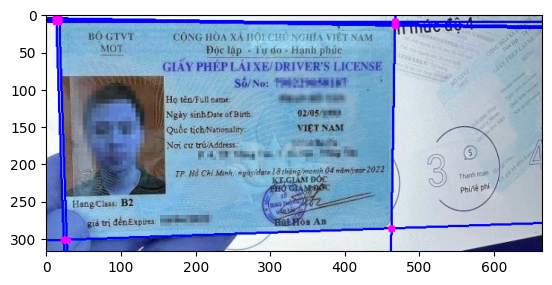

In [ ]:
img_intersection = img_lines.copy()

for x, y in intersections:
    cv2.circle(img_intersection, (x, y), 5, (255, 0, 255), -1)

plt.imshow(img_intersection)

In [ ]:
points = np.array(intersections, dtype=np.float32)

In [ ]:
kmeans = KMeans(4, random_state=0).fit(points)

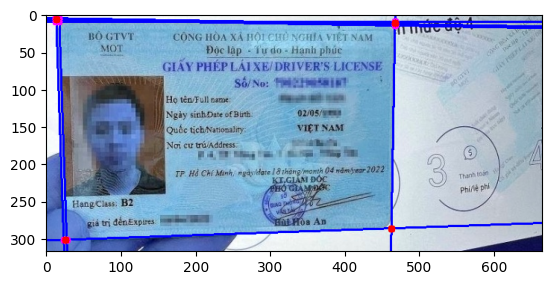

In [ ]:
center = kmeans.cluster_centers_
img_kmeans = img_intersection.copy()

for x, y in center:
    cv2.circle(img_kmeans, (int(x), int(y)), 5, (255, 0, 0), -1)

plt.imshow(img_kmeans)

In [ ]:
def order_corners(pts):
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    return np.array([
        pts[np.argmin(s)],      # top-left
        pts[np.argmin(diff)],   # top-right
        pts[np.argmax(s)],      # bottom-right
        pts[np.argmax(diff)]    # bottom-left
    ], dtype=np.float32)

ordered_corners = order_corners(center)

In [ ]:
(tl, tr, br, bl) = ordered_corners

# Chiều rộng (max giữa cạnh trên và dưới)
widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))

# Chiều cao (max giữa cạnh trái và phải)
heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))

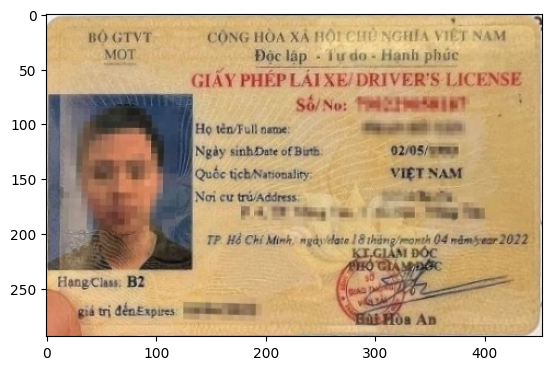

In [ ]:
img_rotate = img.copy()

dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]
], dtype="float32")

# Tính ma trận transform
M = cv2.getPerspectiveTransform(ordered_corners, dst)

# Áp dụng warp để xoay lại ảnh ID card
warped = cv2.warpPerspective(img_rotate, M, (maxWidth, maxHeight))

plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))